# Load Data

In [1]:
import pandas as pd
import platform
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import defaultdict
import joblib
import json
import warnings
import time
from scipy.stats.mstats import winsorize
import numba
import pandas_ta as pta

import sys
import os

# Add one directory up to sys.path
sys.path.append(os.path.abspath(".."))

# Internal Libraries
from data_loader import load_and_resample_data, apply_feature_engineering
from backtest import evaluate_regression
from labeling_utils import label_and_save
from helpers import check_overfit, generate_oof_predictions, is_same_session
#

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber, MeanSquaredError
import tensorflow as tf
#

# Scikit-learn
from sklearn.base import clone, BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_val_predict
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier, ElasticNet, Ridge, ElasticNetCV, RidgeCV
from sklearn.metrics import classification_report, root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, \
    confusion_matrix, precision_recall_curve, roc_curve, auc, accuracy_score, classification_report, f1_score, precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

# Models and Training
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import optuna
import seaborn as sns
import shap
from sklearn.svm import SVC
#

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*There are no meaningful features.*", category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.INFO)

market = "NQ"

# Initialize features or indicators

In [2]:
# This is your Cell 5: Feature Engineering Function Definitions

# --- Helper Functions for Custom Features (Some will be kept, some modified/called differently) ---
# These helpers now expect columns to be named as pandas_ta typically names them (e.g., RSI_14, EMA_10, MACD_12_26_9, etc.)
# def add_market_regime_features(df, suffix=''):
#     chop_col = f'CHOP_14_1_100{suffix}'
#     adx_col = f'ADX_14{suffix}'
#     atr_col = f'ATR_14_5min'  # Use base_tf for ATR

#     # Handle missing data
#     if any(col not in df.columns for col in [chop_col, adx_col, atr_col]):
#         raise ValueError(f"Required columns not found for regime detection: {chop_col}, {adx_col}, {atr_col}")

#     atr_thresh = df[atr_col].rolling(100, min_periods=20).mean() * 1.1

#     df['Is_Trending'] = (df[adx_col] > 20).astype(int)
#     df['Is_Choppy'] = (df[chop_col] > 60).astype(int)
#     df['Is_High_Vol'] = (df[atr_col] > atr_thresh).astype(int)
#     df['Is_Low_Vol'] = (df[atr_col] <= atr_thresh).astype(int)

#     df['Market_Regime'] = (
#         df['Is_Trending'].astype(str) + "_" +
#         df['Is_High_Vol'].astype(str)
#     )

#     return df


def add_price_vs_ma(df, price_col='close', ma_col_name='EMA_20', new_col_name_suffix='_vs_EMA20'):
    # Ensure ma_col_name exists (it would have been created by pandas_ta)
    if ma_col_name in df.columns and price_col in df.columns:
        # Ensure inputs are numeric before division
        df[price_col + new_col_name_suffix] = pd.to_numeric(df[price_col], errors='coerce') / pd.to_numeric(df[ma_col_name], errors='coerce')
    return df

def add_ma_vs_ma(df, ma1_col_name='EMA_10', ma2_col_name='EMA_20', new_col_name_suffix='_vs_EMA20'):
    if ma1_col_name in df.columns and ma2_col_name in df.columns:
        df[ma1_col_name + new_col_name_suffix] = pd.to_numeric(df[ma1_col_name], errors='coerce') / pd.to_numeric(df[ma2_col_name], errors='coerce')
    return df

def add_ma_slope(df, ma_col_name='EMA_10', new_col_name_suffix='_Slope_10', periods=1):
    if ma_col_name in df.columns:
        df[new_col_name_suffix] = pd.to_numeric(df[ma_col_name], errors='coerce').diff(periods) / periods
    return df

def add_rsi_signals(df, rsi_col_name='RSI_14', ob_level=70, os_level=30):
    if rsi_col_name in df.columns:
        rsi_series = pd.to_numeric(df[rsi_col_name], errors='coerce')
        df[rsi_col_name + f'_Is_Overbought_{ob_level}'] = (rsi_series > ob_level).astype(int)
        df[rsi_col_name + f'_Is_Oversold_{os_level}'] = (rsi_series < os_level).astype(int)
    return df

def add_stoch_signals(df, stoch_k_col_name='STOCHk_14_3_3', ob_level=80, os_level=20): # Default pandas_ta name for k
    if stoch_k_col_name in df.columns:
        stoch_k_series = pd.to_numeric(df[stoch_k_col_name], errors='coerce')
        df[stoch_k_col_name + f'_Is_Overbought_{ob_level}'] = (stoch_k_series > ob_level).astype(int)
        df[stoch_k_col_name + f'_Is_Oversold_{os_level}'] = (stoch_k_series < os_level).astype(int)
    return df

def add_macd_cross_signal(df, macd_col_name='MACD_12_26_9', signal_col_name='MACDs_12_26_9'): # Default pandas_ta name for signal
    if macd_col_name in df.columns and signal_col_name in df.columns:
        macd_series = pd.to_numeric(df[macd_col_name], errors='coerce')
        signal_series = pd.to_numeric(df[signal_col_name], errors='coerce')
        crossed_above = (macd_series > signal_series) & (macd_series.shift(1) < signal_series.shift(1))
        crossed_below = (macd_series < signal_series) & (macd_series.shift(1) > signal_series.shift(1))
        df[macd_col_name + '_Cross_Signal'] = np.where(crossed_above, 1, np.where(crossed_below, -1, 0))
    return df

def add_price_vs_bb(df, price_col='close', bb_upper_col='BBU_20_2.0', bb_lower_col='BBL_20_2.0'): # Default pandas_ta names
    if price_col in df.columns and bb_upper_col in df.columns and bb_lower_col in df.columns:
        price_series = pd.to_numeric(df[price_col], errors='coerce')
        bb_upper_series = pd.to_numeric(df[bb_upper_col], errors='coerce')
        bb_lower_series = pd.to_numeric(df[bb_lower_col], errors='coerce')
        df[price_col + '_vs_BB_Upper'] = (price_series > bb_upper_series).astype(int)
        df[price_col + '_vs_BB_Lower'] = (price_series < bb_lower_series).astype(int)
    return df

# Keep these custom functions as they are generally good:
def add_daily_vwap(df, high_col='high', low_col='low', close_col='close', volume_col='volume', new_col_name='VWAP_D'): # Changed name to VWAP_D for daily
    # ... (your existing robust add_daily_vwap function - ensure it uses .copy() and numeric conversions internally)
    # Make sure the final column is named VWAP_D or adjust add_price_vs_ma call later
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index must be DatetimeIndex for daily VWAP.")
        return df
    df_temp = df.copy()
    for col in [high_col, low_col, close_col, volume_col]:
        df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    tpv = ((df_temp[high_col] + df_temp[low_col] + df_temp[close_col]) / 3) * df_temp[volume_col]
    cumulative_tpv = tpv.groupby(df_temp.index.date).cumsum()
    cumulative_volume = df_temp[volume_col].groupby(df_temp.index.date).cumsum()
    vwap_series = cumulative_tpv / cumulative_volume
    df[new_col_name] = vwap_series.replace([np.inf, -np.inf], np.nan)
    return df


def add_candle_features(df):
    # ... (your existing add_candle_features function - ensure numeric conversions) ...
    df_temp = df.copy()
    for col in ['open', 'high', 'low', 'close']:
        df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    df['Candle_Range'] = df_temp['high'] - df_temp['low']
    df['Candle_Body'] = (df_temp['close'] - df_temp['open']).abs()
    df['Upper_Wick'] = df_temp['high'] - np.maximum(df_temp['open'], df_temp['close'])
    df['Lower_Wick'] = np.minimum(df_temp['open'], df_temp['close']) - df_temp['low']
    df['Body_vs_Range'] = (df['Candle_Body'] / df['Candle_Range'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

def add_return_features(df, price_col='close'):
    # ... (your existing add_return_features function - ensure numeric conversions and inf handling) ...
    price_series_num = pd.to_numeric(df[price_col], errors='coerce').replace(0, np.nan)
    df[f'Log_Return_1'] = np.log(price_series_num / price_series_num.shift(1))
    df[f'Log_Return_3'] = np.log(price_series_num / price_series_num.shift(3))
    df[f'Log_Return_6'] = np.log(price_series_num / price_series_num.shift(6))
    df[f'Simple_Return_1'] = price_series_num.pct_change(1)
    for col_ret in [f'Log_Return_1', f'Log_Return_3', f'Log_Return_6', f'Simple_Return_1']:
        if col_ret in df.columns: df[col_ret] = df[col_ret].replace([np.inf, -np.inf], np.nan)
    return df

def add_rolling_stats(df, price_col='close', window1=14, window2=30):
    # ... (your existing add_rolling_stats function - ensure numeric conversions and inf handling) ...
    returns = pd.to_numeric(df[price_col], errors='coerce').pct_change(1).replace([np.inf, -np.inf], np.nan)
    df[f'Rolling_Std_Dev_{window1}'] = returns.rolling(window=window1).std()
    df[f'Rolling_Skew_{window2}'] = returns.rolling(window=window2).skew()
    df[f'Rolling_Kurtosis_{window2}'] = returns.rolling(window=window2).kurt()
    return df

def add_lagged_features(df, cols_to_lag, lags=[1, 3, 6]):
    # ... (your existing add_lagged_features function - ensure numeric conversions on source col if needed) ...
    for col_orig in cols_to_lag:
        if col_orig in df.columns:
            series_to_lag = pd.to_numeric(df[col_orig], errors='coerce')
            for lag in lags:
                df[f'{col_orig}_Lag_{lag}'] = series_to_lag.shift(lag)
    return df

def add_trend_features(df_input, suffix=''):
    """
    Add trend, volatility regime, and momentum features with proper suffix handling.
    Assumes standard column names from pandas_ta (e.g., EMA_20, VWAP_D, etc.)
    """
    df = df_input.copy()
    
    # Ensure we have the base columns with correct suffixes
    required_cols = [
        f'EMA_20{suffix}', f'EMA_50{suffix}', 
        f'VWAP_D{suffix}', f'ATR_14{suffix}',
        f'RSI_14{suffix}', f'close'
    ]
    
    if not all(col in df.columns for col in required_cols):
        print(f"Warning: Missing some required columns for trend features with suffix {suffix}")
        return df

    # Trend Direction using EMAs
    df[f'Trend_Direction{suffix}'] = np.where(
        df[f'EMA_20{suffix}'] > df[f'EMA_50{suffix}'], 1, -1
    )
    
    # Price vs VWAP (normalized)
    df[f'Price_vs_VWAP{suffix}'] = (
        df['close'] / df[f'VWAP_D{suffix}'] - 1
    ) * 100  # Convert to percentage
    
    # Volatility Regime (normalized)
    vol_short = df[f'ATR_14{suffix}'].rolling(24).mean()
    vol_long = df[f'ATR_14{suffix}'].rolling(120).mean()
    df[f'Vol_Regime{suffix}'] = (vol_short / vol_long - 1) * 100
    
    # Momentum Confirmation (multiple timeframe alignment)
    df[f'RSI_Trend_Align{suffix}'] = (
        (df[f'RSI_14{suffix}'] > 50) & 
        (df[f'EMA_20{suffix}'] > df[f'EMA_50{suffix}'])
    ).astype(int)
    
    return df


# --- Main Feature Generation Function using pandas_ta ---
def add_all_features(df_input, suffix=''):
    """
    Adds technical indicators and derived features using pandas_ta.
    Assumes df_input has 'open', 'high', 'low', 'close', 'volume' columns (DatetimeIndex).
    """
    if not isinstance(df_input.index, pd.DatetimeIndex):
        print(f"Warning: DataFrame for suffix '{suffix}' does not have a DatetimeIndex.")
    
    df = df_input.copy() # Work on a copy

    # Ensure base OHLCV columns are numeric and present
    base_cols = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in base_cols):
         raise ValueError(f"DataFrame must contain {base_cols}. Found: {df.columns.tolist()}")
    for col in base_cols: # Ensure correct dtypes for pandas_ta
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=base_cols, inplace=True) # Drop rows if OHLCV became NaN

    if df.empty:
        print(f"DataFrame became empty after coercing OHLCV for suffix '{suffix}'. Returning empty DataFrame.")
        # Return an empty dataframe with expected suffixed columns if possible or raise error
        # For simplicity, we'll let it create columns that will be all NaN, then suffixing will apply.
        # Or handle more gracefully by creating expected columns with NaNs.
        # For now, we will proceed, and suffixing will apply to what gets created.
        pass


    print(f"DataFrame shape for pandas_ta (suffix: {suffix}): {df.shape}")

    # I. Technical Indicators using pandas_ta
    # Most pandas_ta functions automatically name columns (e.g., SMA_10, RSI_14)
    # and handle NaNs internally. `append=True` adds them to df.

    # Volume
    df.ta.sma(close=df['volume'], length=20, append=True, col_names=('Volume_SMA_20'))
    df = add_daily_vwap(df, new_col_name='VWAP_D') # Using your custom daily VWAP, named VWAP_D
    df = add_price_vs_ma(df, ma_col_name='VWAP_D', new_col_name_suffix='_vs_VWAP_D')

    # Volatility
    df.ta.bbands(length=20, std=2, append=True) # Creates BBL_20_2.0, BBM_20_2.0, BBU_20_2.0, BBB_20_2.0, BBP_20_2.0
    # Helpers will need these names: BBU_20_2.0, BBL_20_2.0
    df = add_price_vs_bb(df, bb_upper_col='BBU_20_2.0', bb_lower_col='BBL_20_2.0')
    df.ta.atr(length=14, append=True, col_names=('ATR_14')) # pandas_ta might name it ATRr_14 or similar. We force ATR_14.

    # Trend
    df.ta.sma(length=10, append=True) # SMA_10
    df.ta.sma(length=20, append=True) # SMA_20 (also BBM_20_2.0 from bbands)
    df.ta.sma(length=50, append=True) # SMA_50
    df.ta.ema(length=10, append=True) # EMA_10
    df.ta.ema(length=20, append=True) # EMA_20
    df.ta.ema(length=50, append=True) # EMA_50
    
    df = add_price_vs_ma(df, ma_col_name='EMA_20', new_col_name_suffix='_vs_EMA20')
    df = add_ma_vs_ma(df, ma1_col_name='EMA_10', ma2_col_name='EMA_20', new_col_name_suffix='_vs_EMA20')
    df = add_ma_slope(df, ma_col_name='EMA_10', new_col_name_suffix='_Slope_10')

    df.ta.macd(fast=12, slow=26, signal=9, append=True) # MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9
    df = add_macd_cross_signal(df, macd_col_name='MACD_12_26_9', signal_col_name='MACDs_12_26_9')

    df.ta.adx(length=14, append=True) # ADX_14, DMP_14, DMN_14
    # Rename DMN_14 and DMP_14 to match your old Minus_DI_14, Plus_DI_14 if helpers depend on it
    if 'DMP_14' in df.columns: df.rename(columns={'DMP_14': 'Plus_DI_14'}, inplace=True)
    if 'DMN_14' in df.columns: df.rename(columns={'DMN_14': 'Minus_DI_14'}, inplace=True)

    df.ta.cci(length=20, append=True, col_names=('CCI_20')) # pandas_ta uses CCI_20_0.015 by default

    # Momentum
    df.ta.rsi(length=14, append=True) # RSI_14
    df = add_rsi_signals(df, rsi_col_name='RSI_14')
    df.ta.chop(length=14, append=True)  # Adds column: CHOP_14

    df.ta.willr(length=14, append=True)  # Adds column: WILLR_14

    
    df.ta.stoch(k=14, d=3, smooth_k=3, append=True) # STOCHk_14_3_3, STOCHd_14_3_3
    df = add_stoch_signals(df, stoch_k_col_name='STOCHk_14_3_3')

    df.ta.ppo(fast=12, slow=26, signal=9, append=True) # PPO_12_26_9, PPOh_12_26_9, PPOs_12_26_9
    df.ta.roc(length=10, append=True) # ROC_10
    
    # Explicitly convert PPO and ROC to numeric (belt and braces after pandas_ta)
    for col_name in ['PPO_12_26_9', 'ROC_10']: # Check exact names if pandas_ta produces variants
        base_name_ppo = [c for c in df.columns if "PPO_" in c and "PPOh" not in c and "PPOs" not in c]
        base_name_roc = [c for c in df.columns if "ROC_" in c]
        
        for actual_col_name in base_name_ppo + base_name_roc:
            if actual_col_name in df.columns:
                df[actual_col_name] = df[actual_col_name].replace([np.inf, -np.inf], np.nan)
                df[actual_col_name] = pd.to_numeric(df[actual_col_name], errors='coerce')

    # II. Price Action & Basic Features (Keep your custom functions)
    df = add_candle_features(df)
    # df = add_candlestick_patterns(df) # We'll replace this with pandas_ta candlestick patterns

    # --- pandas_ta Candlestick Patterns ---
    # Example: Add Doji, Hammer, Engulfing. pandas_ta has many more.
    # 'name="all"' would add many columns, so be selective or use a list.
    candle_patterns_to_check = ["doji", "hammer", "engulfing"] 
    df.ta.cdl_pattern(name=candle_patterns_to_check, append=True)
    # Rename columns to match your old convention if needed, e.g., CDLDOJI -> Is_Doji
    if 'CDLDOJI' in df.columns: df.rename(columns={'CDLDOJI': 'Is_Doji_pta'}, inplace=True) # Add _pta to distinguish
    if 'CDLHAMMER' in df.columns: df.rename(columns={'CDLHAMMER': 'Is_Hammer_pta'}, inplace=True)
    if 'CDLENGULFING' in df.columns: df.rename(columns={'CDLENGULFING': 'Is_Engulfing_pta'}, inplace=True) # This is a general engulfing signal (+/-)

    df = add_return_features(df)

    # III. Statistical Features (Keep your custom functions)
    df = add_rolling_stats(df)
    
    # Lagged Features
    # Ensure base columns for lagging are the ones created by pandas_ta or your helpers
    cols_to_lag_pta = ['close', 'RSI_14', 'Candle_Body', 'Volume_SMA_20'] 
    # Check if these columns actually exist, as pandas_ta might name them slightly differently
    # This valid_cols_to_lag should use the names as they are in df at this point
    valid_cols_to_lag = [col for col in cols_to_lag_pta if col in df.columns]
    df = add_lagged_features(df, valid_cols_to_lag, lags=[1,2,3])
    # df = add_market_regime_features(df)

    # --- Suffixing ---
    # All columns created by pandas_ta (that were appended) or by helpers
    # that are not the original 'open', 'high', 'low', 'close', 'volume' will be suffixed.
    current_cols = list(df.columns)
    # Identify features generated in this function call (not the original base OHLCV)
    generated_feature_cols = [col for col in current_cols if col not in base_cols]
    
    rename_dict = {col: col + suffix for col in generated_feature_cols}
    df.rename(columns=rename_dict, inplace=True)
    
    return df

def add_trend_features(df_input, suffix=''):
    """
    Enhanced trend features with proper suffix handling.
    Assumes standard column names from pandas_ta with appropriate suffixes.
    """
    df = df_input.copy()
    
    # Required columns check with suffix
    required_cols = [
        f'EMA_20{suffix}', f'EMA_50{suffix}', 
        f'VWAP_D{suffix}', f'ATR_14{suffix}',
        f'RSI_14{suffix}', f'MACD_12_26_9{suffix}',
        f'BBM_20_2.0{suffix}',  # BB middle band
        'close', 'volume'  # Base columns without suffix
    ]
    
    if not all(col in df.columns for col in required_cols):
        print(f"Warning: Missing some required columns for trend features with suffix {suffix}")
        return df

    # 1. Trend Direction Features
    df[f'Trend_Direction{suffix}'] = np.where(
        df[f'EMA_20{suffix}'] > df[f'EMA_50{suffix}'], 1, -1
    )
    
    # 2. Trend Strength (normalized)
    df[f'Trend_Strength{suffix}'] = (
        (df[f'EMA_20{suffix}'] - df[f'EMA_50{suffix}']) / 
        df[f'ATR_14{suffix}']
    ).rolling(20).mean()
    
    # 3. Price vs Moving Averages (percentage based)
    df[f'Price_vs_EMA20{suffix}'] = (
        (df['close'] - df[f'EMA_20{suffix}']) / 
        df[f'EMA_20{suffix}'] * 100
    )
    
    # 4. VWAP-based trend
    df[f'Price_vs_VWAP{suffix}'] = (
        (df['close'] - df[f'VWAP_D{suffix}']) / 
        df[f'VWAP_D{suffix}'] * 100
    )
    
    # 5. Volatility Regime Features
    vol_short = df[f'ATR_14{suffix}'].rolling(24).mean()
    vol_long = df[f'ATR_14{suffix}'].rolling(120).mean()
    df[f'Vol_Regime{suffix}'] = (
        (vol_short / vol_long - 1) * 100
    ).fillna(0)
    
    # 6. Volume-Weighted Trend
    volume_ma = df['volume'].rolling(20).mean()
    df[f'Volume_Trend{suffix}'] = (
        df['volume'] / volume_ma - 1
    ) * df[f'Trend_Direction{suffix}']
    
    # 7. Multi-Indicator Trend Alignment
    df[f'Trend_Alignment{suffix}'] = (
        (df[f'EMA_20{suffix}'] > df[f'EMA_50{suffix}']) &  # EMA trend
        (df['close'] > df[f'VWAP_D{suffix}']) &            # Above VWAP
        (df[f'RSI_14{suffix}'] > 50) &                     # RSI momentum
        (df[f'MACD_12_26_9{suffix}'] > 0)                  # MACD positive
    ).astype(int)
    
    # 8. Mean Reversion Potential
    df[f'Mean_Reversion{suffix}'] = (
        (df['close'] - df[f'BBM_20_2.0{suffix}']) / 
        df[f'ATR_14{suffix}']
    ).rolling(10).mean()
    
    # 9. Trend Acceleration
    df[f'Trend_Acceleration{suffix}'] = (
        df[f'EMA_20{suffix}'].diff() - 
        df[f'EMA_50{suffix}'].diff()
    ) / df[f'ATR_14{suffix}']
    
    # 10. Composite Trend Score (-100 to +100)
    df[f'Trend_Score{suffix}'] = (
        (df[f'Trend_Direction{suffix}'] * 20) +                    # Base direction
        (df[f'Price_vs_EMA20{suffix}'].clip(-20, 20)) +          # Price vs EMA
        (df[f'RSI_14{suffix}'] - 50) +                           # RSI contribution
        (np.sign(df[f'MACD_12_26_9{suffix}']) * 10) +           # MACD direction
        (df[f'Volume_Trend{suffix}'].clip(-20, 20)) +           # Volume trend
        (df[f'Trend_Alignment{suffix}'] * 20)                    # Alignment bonus
    ).clip(-100, 100)
    
    return df

# --- Time & Session Features (Keep as is) ---
def add_time_session_features(df):
    # ... (your existing add_time_session_features function) ...
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index must be DatetimeIndex for time/session features.")
        return df
    df = df.copy()
    df['Hour_of_Day'] = df.index.hour
    df['Minute_of_Hour'] = df.index.minute
    df['Day_of_Week'] = df.index.dayofweek
    time_fraction_of_day = df['Hour_of_Day'] + df['Minute_of_Hour'] / 60.0
    df['Time_Sin'] = np.sin(2 * np.pi * time_fraction_of_day / 24.0)
    df['Time_Cos'] = np.cos(2 * np.pi * time_fraction_of_day / 24.0)
    df['Day_Sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7.0)
    df['Day_Cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7.0)
    df['Is_Asian_Session'] = ((df['Hour_of_Day'] >= 20) | (df['Hour_of_Day'] < 5)).astype(int)
    df['Is_London_Session'] = ((df['Hour_of_Day'] >= 3) & (df['Hour_of_Day'] < 12)).astype(int)
    df['Is_NY_Session'] = ((df['Hour_of_Day'] >= 8) & (df['Hour_of_Day'] < 17)).astype(int)
    df['Is_Overlap'] = ((df['Hour_of_Day'] >= 8) & (df['Hour_of_Day'] < 12)).astype(int)
    df['Is_US_Open_Hour'] = ((df['Hour_of_Day'] == 9) & (df['Minute_of_Hour'] >= 30) | (df['Hour_of_Day'] == 10) & (df['Minute_of_Hour'] < 30)).astype(int)
    df['Is_US_Close_Hour'] = ((df['Hour_of_Day'] == 15) | (df['Hour_of_Day'] == 16) & (df['Minute_of_Hour'] == 0)).astype(int)
    return df

In [3]:
avoid_funcs = {
    #'avoid_hour_18_19': avoid_hour_18_19
    #'news_window': avoid_news,
}

param_grid_strategy = {
    'SL_ATR_MULT': [1.0, 1.5, 2.0],  # Wider stops
    'TP_ATR_MULT': [3.0, 4.0, 5.0, 8.0],   # More conservative targets
    'TRAIL_START_MULT': [1.0, 1.5],    # Let winners run
    'TRAIL_STOP_MULT': [0.8, 1.0],     # Tighter trailing stops
    'TICK_VALUE': [20],
}

keys, values = zip(*param_grid_strategy.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]

# Cleanup

In [4]:
df_1min, resampled = load_and_resample_data(market, timeframes=['5min', '15min','1h'])

df_5min = resampled['5min']
df_15min = resampled['15min']
df_1hr = resampled['1h']

print("5min shape:", df_5min.shape)
print("15min shape:", df_15min.shape)
print("1h shape:", df_1hr.shape)


df_merged = apply_feature_engineering(
    resampled=resampled,
    add_all_features=add_all_features,
    add_time_session_features=add_time_session_features,
    add_trend_features=add_trend_features,  # Pass your trend features function here
    timeframes=['5min', '15min', '1h'],
    base_tf='5min'
)

# Add this code right after the feature engineering but before model fitting

print(f"Original merged dataset shape: {df_merged.shape}")

# Count rows with at least one NaN
nan_rows_count = df_merged.isna().any(axis=1).sum()
total_rows = len(df_merged)
print(f"Rows with at least one NaN: {nan_rows_count} out of {total_rows} ({(nan_rows_count/total_rows)*100:.2f}%)")


# Verify Data
# def check_feature_alignment(df_merged, tf_suffix, feature_keyword, sample_times):
#     """
#     Check if features from the correct timeframe are available and what values they have at key timestamps.
#     """
#     suffix_str = f"_{tf_suffix}"
#     matching_cols = [col for col in df_merged.columns if feature_keyword in col and col.endswith(suffix_str)]
    
#     print(f"\n🔍 Checking features containing '{feature_keyword}' with suffix '{suffix_str}'")

#     if not matching_cols:
#         print(f"⚠️ No matching columns found. Available columns ending with {suffix_str}:")
#         sample_suffix_cols = [col for col in df_merged.columns if col.endswith(suffix_str)]
#         print(sample_suffix_cols[:10])  # Show only first 10 to keep it clean
#         return

#     for time in sample_times:
#         if time not in df_merged.index:
#             print(f"❌ Time {time} not found in df_merged index.")
#         else:
#             print(f"\n⏰ At time {time} — values:")
#             print(df_merged.loc[time, matching_cols])

# sample_times = [
#     pd.Timestamp("2022-01-05 12:05:00-05:00"),
#     pd.Timestamp("2022-01-05 12:15:00-05:00"),
#     pd.Timestamp("2022-01-05 12:59:00-05:00"),
#     pd.Timestamp("2022-01-05 13:00:00-05:00")
# ]

# check_feature_alignment(df_merged, tf_suffix="1h", feature_keyword="RSI", sample_times=sample_times)
# check_feature_alignment(df_merged, tf_suffix="15min", feature_keyword="MACD", sample_times=sample_times)
# check_feature_alignment(df_merged, tf_suffix="5min", feature_keyword="EMA", sample_times=sample_times)


📁 Found matching folder: ./../data/NQ
5min shape: (300923, 5)
15min shape: (100530, 5)
1h shape: (25383, 5)
--- Starting Feature Engineering Execution ---

Generating features for timeframe: 5min — shape: (300923, 5)
DataFrame shape for pandas_ta (suffix: _5min): (300923, 5)
Adding trend features for timeframe: 5min
Output shape for 5min: (300923, 83)

Generating features for timeframe: 15min — shape: (100530, 5)
DataFrame shape for pandas_ta (suffix: _15min): (100530, 5)
Adding trend features for timeframe: 15min
Output shape for 15min: (100530, 83)

Generating features for timeframe: 1h — shape: (25383, 5)
DataFrame shape for pandas_ta (suffix: _1h): (25383, 5)
Adding trend features for timeframe: 1h
Output shape for 1h: (25383, 83)

Adding time/session features to base timeframe: 5min

Merging additional timeframe features into base...
--- Feature Engineering Execution COMPLETE ---
Final df_merged shape: (300923, 252)
Original merged dataset shape: (300923, 252)
Rows with at least o

In [5]:
labeled = label_and_save(
    df_input_features=df_merged,
    lookahead_period=12,
    vol_col_name='ATR_14_5min',
    pt_multiplier=2.0,
    sl_multiplier=1.0,
    min_return_percentage=0.0005,
    output_file_suffix=f'L12_PT2SL1VB12{market}',
    feature_columns_for_dropna=[]
)


--- Processing for output suffix: L12_PT2SL1VB12NQ ---
Adding Regression Targets...
reg_value NaNs: 14
reg_side  NaNs: 0

Adding Classification Target: clf_target_numba_pt2.0sl1.0vb12 ...
clf_target_numba_pt2.0sl1.0vb12 NaNs: 0
Rows after dropping NaNs from targets: 300909
✅ Saved parquet/labeled_data_L12_PT2SL1VB12NQ.parquet with 300909 rows


# Train

##### Real Training

In [6]:
selected_indicators = [
    # ─── Volume & Volatility ────────────────────────────────────────────────
    "ATR_14_5min",
    "ATR_14_15min",
    "Volume_SMA_20_5min",
    "Volume_SMA_20_Lag_1_5min",

    # ─── Raw Regime Flags (needed because your labels switch SL/TP by ADX/CHOP) ──
    "ADX_14_5min",
    "CHOP_14_1_100_5min",
    # (optional: if you run add_market_regime_features, you could also include “Is_Trending”/“Is_Choppy” here)

    # ─── Trend / Momentum ─────────────────────────────────────────────────────
    "RSI_14_5min",
    "RSI_14_1h",
    "MACDh_12_26_9_1h",                # MACD histogram on 1h
    "EMA_20_5min",
    "MACD_12_26_9_Cross_Signal_5min",
    "STOCHk_14_3_3_5min",

    # ─── Composite Trend Signals ─────────────────────────────────────────────
    "Trend_Score_5min",                # Composite of RSI, EMA alignment, VWAP, etc.
    "Trend_Alignment_5min",            # 1 iff (EMA alignment & RSI>50 & MACD>0 & close>VWAP)
    "Price_vs_VWAP_5min",              # (close / VWAP) – 1, in percent

    # ─── Bollinger Mean Reversion ────────────────────────────────────────────
    "close_vs_BB_Upper_5min",               # 1 if close > upper BB20‐2σ, else 0
    "close_vs_BB_Lower_5min",               # 1 if close < lower BB20‐2σ, else 0

    # ─── CCI (Commodity Channel Index) ───────────────────────────────────────
    "CCI_20_5min",                     # pandas_ta’s CCI_20 on 5m

    # ─── Statistical Features ─────────────────────────────────────────────────
    "Rolling_Std_Dev_14_5min",         # 14-bar std of 5m simple return
    "Rolling_Skew_30_5min",            # 30-bar skew of 5m simple return
    "Rolling_Kurtosis_30_5min",        # 30-bar kurtosis of 5m simple return

    # ─── Lagged Versions of Key Signals ──────────────────────────────────────
    "RSI_14_Lag_1_5min",
    "Candle_Body_Lag_1_5min",

    # ─── Session + Time Context ──────────────────────────────────────────────
    "Is_NY_Session",
    "Is_Asian_Session",
    "Hour_of_Day",
    "Time_Cos",

    # ─── Price Action ─────────────────────────────────────────────────────────
    "WILLR_14_5min",
    # (drop “Simple_Return_1_5min” here, since its corr ≈0.0009; model will see it via rolling stats)
    "Body_vs_Range_5min",
    "Upper_Wick_5min",

    # ─── Macro / Higher‐Timeframe Anchors ────────────────────────────────────
    "VWAP_D_1h"                        # Daily VWAP computed on 1h bars
]

In [7]:
class CNN1DWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_shape, filters=64, kernel_size=3, dropout=0.2, learning_rate=0.001):
        self.input_shape = input_shape
        self.filters = filters
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self):
        model = Sequential([
            Conv1D(self.filters, kernel_size=self.kernel_size, activation='relu', input_shape=(self.input_shape, 1)),
            Dropout(self.dropout),
            Conv1D(self.filters * 2, kernel_size=self.kernel_size, activation='relu'),
            Dropout(self.dropout),
            GlobalAveragePooling1D(),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def fit(self, X, y, **kwargs):
        X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
        self.model = self.build_model()
        self.model.fit(
            X_reshaped, y,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
            ],
            verbose=0
        )
        return self

    def predict(self, X):
        X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
        return self.model.predict(X_reshaped).flatten()

In [8]:
class LSTMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_shape, units=64, dropout=0.2, learning_rate=0.001):
        self.input_shape = input_shape
        self.units = units
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self):
        model = Sequential([
            LSTM(self.units, input_shape=(self.input_shape, 1), return_sequences=True),
            Dropout(self.dropout),
            LSTM(self.units // 2, return_sequences=False),
            Dropout(self.dropout),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def fit(self, X, y, **kwargs):
        X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
        self.model = self.build_model()
        self.model.fit(
            X_reshaped, y,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
            ],
            verbose=0
        )
        return self

    def predict(self, X):
        X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
        return self.model.predict(X_reshaped).flatten()

In [9]:
def run_lookahead_for_session_regression(LOOKAHEAD):
    # === Load data ===
    path = f"parquet/labeled_data_L12_PT2SL1VB12{market}.parquet"
    labeled = pd.read_parquet(path)

    # === Ensure datetime column exists and is parsed ===
    if labeled.index.name == 'datetime' or pd.api.types.is_datetime64_any_dtype(labeled.index):
        labeled = labeled.reset_index()
    if 'datetime' not in labeled.columns:
        raise KeyError("❌ 'datetime' column is missing.")

    labeled['datetime'] = pd.to_datetime(labeled['datetime'])
    labeled = labeled.sort_values('datetime')

    # Plot raw distribution
    plt.figure(figsize=(10, 5))
    labeled['reg_value'].hist(bins=200)
    plt.title("Distribution of Raw Target (reg_value)")
    plt.xlabel("Target Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    labeled['reg_side'].hist(bins=200)
    plt.title("Distribution of Raw Target (reg_side)")
    plt.xlabel("Target Side")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # === Train/test split ===
    cutoff_date = pd.Timestamp("2025-01-01", tz="America/New_York")
    train = labeled[labeled['datetime'] < cutoff_date]
    test = labeled[labeled['datetime'] >= cutoff_date]

    train = train.set_index('datetime')
    test = test.set_index('datetime')

    # === Feature selection ===
    X_train = train[selected_indicators]
    X_test = test[selected_indicators]

    # === Find regression target column ===
    reg_cols = [col for col in labeled.columns if col.startswith("reg_value")]
    if not reg_cols:
        raise ValueError("❌ No regression target column found starting with 'reg_value'.")
    reg_col = reg_cols[0]
    print(f"📌 Using regression target column: {reg_col}")

    y_train_seq = train[reg_col]
    y_test_seq = test[reg_col]

    print(f"Train range: {train.index.min()} to {train.index.max()} | Rows: {len(train)}")
    print(f"Test range: {test.index.min()} to {test.index.max()} | Rows: {len(test)}")

    # Example: Remove near-constant features (threshold can be tuned)
    selector = VarianceThreshold(threshold=1e-4)
    selector.fit(X_train)

    low_variance_features = X_train.columns[~selector.get_support()]
    print(f"📉 Low variance features ({len(low_variance_features)}): {list(low_variance_features)}")

    correlations = X_train.corrwith(y_train_seq).sort_values(key=lambda x: abs(x), ascending=False)
    print("📊 Top correlated features with target:")
    print(correlations.head(20))

    print("\n🚫 Weak or inverse correlations:")
    print(correlations.tail(20))

    ###########################
    ########## Models #########
    ###########################    
    def tune_catboost_regressor(X, y, loss_function="RMSE", study_name="catboost-default", db_path="dbs/catboost.db", n_trials=10):
        def objective(trial):
            params = {
                "iterations": trial.suggest_int("iterations", 100, 1000, step=50),
                "depth": trial.suggest_int("depth", 4, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
                "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
                "loss_function": loss_function
            }
            model = CatBoostRegressor(**params, verbose=0)
            scores = cross_val_score(
                model, X, y,
                cv=TimeSeriesSplit(n_splits=4),
                scoring="neg_mean_squared_error",
                n_jobs=-1
            )
            return scores.mean()

        study = optuna.create_study(
            direction="maximize",
            study_name=study_name,
            storage=f"sqlite:///{db_path}",
            load_if_exists=True
        )
        study.optimize(objective, n_trials=n_trials)
        return study.best_trial.params
    
    def tune_lgbm_regressor(X, y, objective="rmse", study_name="lgbm-default", db_path="dbs/lgbm.db", n_trials=10):
        def objective_fn(trial):
            params = {
                "objective": objective,
                "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 15, 255, step=16),
                "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
                "importance_type": "gain"
            }

            model = lgb.LGBMRegressor(**params)
            scores = cross_val_score(
                model, X, y,
                cv=TimeSeriesSplit(n_splits=4),
                scoring="neg_mean_squared_error",
                n_jobs=-1
            )
            return scores.mean()

        study = optuna.create_study(
            direction="maximize",
            study_name=study_name,
            storage=f"sqlite:///{db_path}",
            load_if_exists=True
        )
        study.optimize(objective_fn, n_trials=n_trials)
        return study.best_trial.params
    
    def tune_meta_catboost_regressor(X, y):
        def objective(trial):
            params = {
                "iterations": trial.suggest_int("iterations", 50, 500, step=50),
                "depth": trial.suggest_int("depth", 2, 6),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
                "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
            }
            model = CatBoostRegressor(**params, verbose=0)
            scores = cross_val_score(
                model, X, y,
                cv=TimeSeriesSplit(n_splits=4),
                scoring="neg_mean_squared_error",
                n_jobs=-4
            )
            return scores.mean()

        study = optuna.create_study(
            direction="maximize",
            study_name=f"meta-catboost-stack-{LOOKAHEAD}",
            storage="sqlite:///dbs/meta_catboost.db",
            load_if_exists=True
        )
        study.optimize(objective, n_trials=20)
        return study.best_trial.params

    ################################################
    ####### Tune models
    catboost_params_up      = tune_catboost_regressor(X_train, y_train_seq, loss_function="Quantile:alpha=0.7", study_name=f"catboost-up{LOOKAHEAD}{market}")
    catboost_params_down    = tune_catboost_regressor(X_train, y_train_seq, loss_function="Quantile:alpha=0.3", study_name=f"catboost-down{LOOKAHEAD}{market}")
    lgbm_params_huber = tune_lgbm_regressor(X_train, y_train_seq, objective="huber", study_name=f"lgbm-huber{LOOKAHEAD}{market}")
    lgbm_params_rmse = tune_lgbm_regressor(X_train, y_train_seq, objective="rmse", study_name=f"lgbm-rmse{LOOKAHEAD}{market}")

    ################################################
    ####### Train models
    ####### Tree Based #######
    catboost_up     = CatBoostRegressor(**catboost_params_up, random_state=42, verbose=0)
    catboost_down   = CatBoostRegressor(**catboost_params_down, random_state=42, verbose=0)
    lgbm_huber      = lgb.LGBMRegressor(**lgbm_params_huber, random_state=42)
    lgbm_rmse       = lgb.LGBMRegressor(**lgbm_params_rmse, random_state=42)

    ################################################
    ####### Base Stacks
    catboost_models = [
        catboost_up,
        catboost_down
    ]
    catboost_oof = generate_oof_predictions(catboost_models, X_train, y_train_seq, splits=4)

    scaler_cb = StandardScaler()
    catboost_oof_scaled = scaler_cb.fit_transform(catboost_oof)

    catboost_meta = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
    catboost_meta.fit(catboost_oof_scaled, y_train_seq)

    lgbm_models = [
        lgbm_huber,
        lgbm_rmse
    ]
    lgbm_oof = generate_oof_predictions(lgbm_models, X_train, y_train_seq, splits=4)

    scaler_lgb = StandardScaler()
    lgbm_oof_scaled = scaler_lgb.fit_transform(lgbm_oof)

    # Train meta-model on LightGBM OOF
    lgbm_meta = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
    lgbm_meta.fit(lgbm_oof_scaled, y_train_seq)

    for model in catboost_models + lgbm_models:
        model.fit(X_train, y_train_seq)

    # For test set (scaled)
    cat_preds = pd.DataFrame({
        f'model_{i}': model.predict(X_test) for i, model in enumerate(catboost_models)
    })
    cat_preds_scaled = scaler_cb.transform(cat_preds)
    catboost_meta_preds = catboost_meta.predict(cat_preds_scaled)

    lgb_preds = pd.DataFrame({
        f'model_{i}': model.predict(X_test) for i, model in enumerate(lgbm_models)
    })
    lgb_preds_scaled = scaler_lgb.transform(lgb_preds)
    lgbm_meta_preds = lgbm_meta.predict(lgb_preds_scaled)

    X_meta_train = pd.DataFrame({
        'catboost_meta': catboost_meta.predict(scaler_cb.transform(catboost_oof)),
        'lgbm_meta': lgbm_meta.predict(scaler_lgb.transform(lgbm_oof))
    })

    final_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
    final_model.fit(X_meta_train, y_train_seq)

    print(X_meta_train.describe())

    # Final prediction
    X_meta_test = pd.DataFrame({
        'catboost_meta': catboost_meta_preds,
        'lgbm_meta': lgbm_meta_preds
    })
    preds_stack = final_model.predict(X_meta_test)

    corr = np.corrcoef(y_test_seq, preds_stack)[0, 1]
    print(f"Correlation with target: {corr:.4f}")

    ################################################
    ####### Evaluate Model
    def evaluate_model(name, model, Xtr, Xte, ytr, yte, transformed=False):
        train_preds = model.predict(Xtr)
        test_preds = model.predict(Xte)

        if transformed:
        # Inverse-transform predictions
            train_preds = np.sign(train_preds) * (np.expm1(np.abs(train_preds)))
            test_preds = np.sign(test_preds) * (np.expm1(np.abs(test_preds)))
            ytr = np.sign(ytr) * (np.expm1(np.abs(ytr)))

        train_mse = mean_squared_error(ytr, train_preds)
        test_mse = mean_squared_error(yte, test_preds)
        overfit_ratio = test_mse / train_mse if train_mse != 0 else float('inf')

        print(f"\n📊 {name} Performance:")
        print(f"Train MSE: {train_mse:.8f}")
        print(f"Test MSE: {test_mse:.8f}")
        print(f"Overfit ratio (Test / Train): {overfit_ratio:.2f}")
        if overfit_ratio > 1.5:
            print("⚠️ Potential overfitting detected.")
        elif overfit_ratio < 0.7:
            print("⚠️ Possibly underfitting.")
        else:
            print("✅ Generalization looks reasonable.")
        return test_preds

    ####### Tree Based #######
    print("\nEvaluation CatBoost UP")
    preds_catboost_up  = evaluate_model("CatBoostRegressorUp", catboost_up, X_train, X_test, y_train_seq, y_test_seq, transformed=True)

    print("\nEvaluation Catboost DOWN")
    preds_catboost_down  = evaluate_model("CatBoostRegressorDown", catboost_down, X_train, X_test, y_train_seq, y_test_seq, transformed=True)

    print("\nEvaluation LGBM Huber")
    preds_lgbm_huber  = evaluate_model("LGBMHuber", lgbm_huber, X_train, X_test, y_train_seq, y_test_seq, transformed=True)

    print("\nEvaluation LGBM RMSE")
    preds_lgbm_rmse  = evaluate_model("LGBMRMSE", lgbm_rmse, X_train, X_test, y_train_seq, y_test_seq, transformed=True)

    ################################################
    ####### Target Distribution
    ####### Sequential #######
    print("\n🔍 Target distribution Seq:")
    print(y_train_seq.describe())

    ################################################
    ####### Choose final model
    ####### Tree Based #######
    for pred in [preds_stack, lgbm_meta_preds, catboost_meta_preds, preds_lgbm_rmse, preds_lgbm_huber, preds_catboost_down, preds_catboost_up]:
        print("\n🔍 Checking prediction variance:")
        print(f"Min: {pred.min():.8f}")
        print(f"Max: {pred.max():.8f}")
        print(f"Mean: {pred.mean():.8f}")
        print(f"Std Dev: {pred.std():.8f}")
        print(f"First 5 Predictions: {pred[:5]}")

        mae = mean_absolute_error(y_test_seq, pred)
        rmse = np.sqrt(mean_squared_error(y_test_seq, pred))
        r2 = r2_score(y_test_seq, pred)

        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")

    # === Ensure datetime is preserved ===
    X_test = X_test.copy()
    X_test["datetime"] = X_test.index

    metadata = {
        "lookahead": LOOKAHEAD,
        "catboost_params_up": catboost_params_up,
        "catboost_params_down": catboost_params_down,
        "lgbm_params_huber": lgbm_params_huber,
        "lgbm_params_rmse": lgbm_params_rmse,
    }
    with open(f"regression_metadata_{LOOKAHEAD}.json", "w") as f:
        json.dump(metadata, f, indent=2)

    joblib.dump(list(X_train.columns), f"pkl/model_features_{market}-12combo.pkl")
    joblib.dump(final_model, f"pkl/stack_model_regression_{market}-12combo.pkl")

    return {
        'lookahead': LOOKAHEAD,
        'preds_stack': preds_stack,
        'X_test': X_test,
        'true_values': y_test_seq
    }

##### Running Train

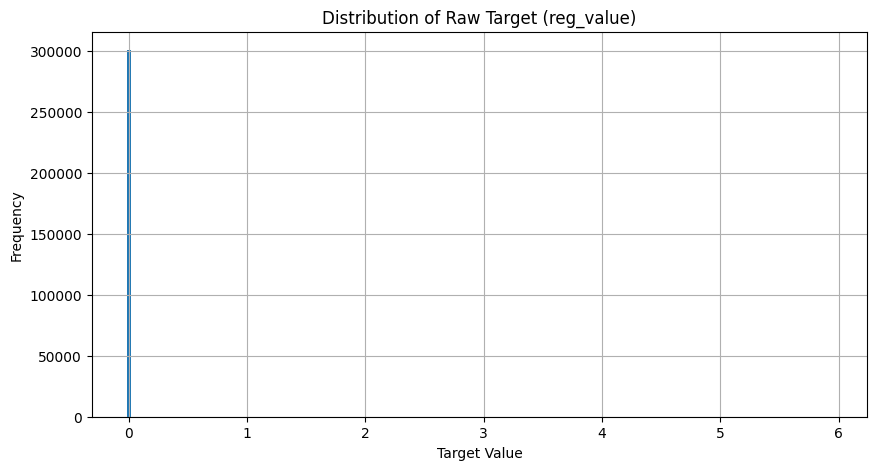

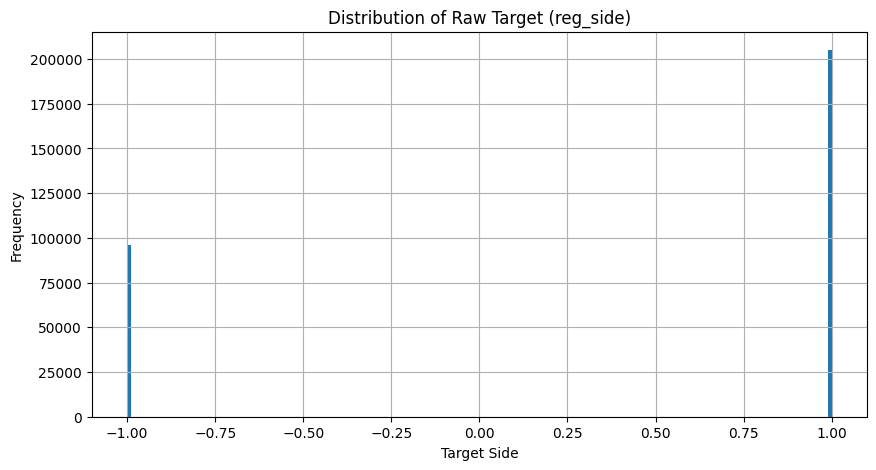

📌 Using regression target column: reg_value
Train range: 2021-03-07 19:10:00-05:00 to 2024-12-31 17:00:00-05:00 | Rows: 271570
Test range: 2025-01-01 18:05:00-05:00 to 2025-06-02 16:00:00-04:00 | Rows: 29339
📉 Low variance features (0): []
📊 Top correlated features with target:
ATR_14_5min                 0.041699
Volume_SMA_20_5min          0.041374
Volume_SMA_20_Lag_1_5min    0.040868
ATR_14_15min                0.037550
Candle_Body_Lag_1_5min      0.035307
Time_Cos                   -0.034144
Is_NY_Session               0.033587
Upper_Wick_5min             0.030182
Is_Asian_Session           -0.024326
ADX_14_5min                 0.015887
EMA_20_5min                -0.015493
VWAP_D_1h                  -0.015375
CHOP_14_1_100_5min         -0.011274
Rolling_Kurtosis_30_5min    0.007210
RSI_14_1h                  -0.007064
Trend_Score_5min           -0.004630
Price_vs_VWAP_5min         -0.004567
Trend_Alignment_5min       -0.004072
RSI_14_Lag_1_5min          -0.002971
RSI_14_5min       

[I 2025-06-04 21:18:54,394] Using an existing study with name 'catboost-up12NQ' instead of creating a new one.
[I 2025-06-04 21:19:31,364] Trial 37 finished with value: -0.00016801856057820474 and parameters: {'iterations': 600, 'depth': 10, 'learning_rate': 0.04813154989863844, 'l2_leaf_reg': 3.476877103121093, 'random_strength': 3.2895718449365337, 'min_data_in_leaf': 12}. Best is trial 23 with value: -0.000167600918153842.
[I 2025-06-04 21:19:58,380] Trial 38 finished with value: -0.00016799408943894776 and parameters: {'iterations': 450, 'depth': 10, 'learning_rate': 0.025084099723442947, 'l2_leaf_reg': 4.164791296256198, 'random_strength': 1.544566838573113, 'min_data_in_leaf': 88}. Best is trial 23 with value: -0.000167600918153842.
[I 2025-06-04 21:20:27,887] Trial 39 finished with value: -0.0001726348556308931 and parameters: {'iterations': 500, 'depth': 10, 'learning_rate': 0.040661976684991205, 'l2_leaf_reg': 2.1575174700699926, 'random_strength': 1.881424685803772, 'min_data

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003959 seconds.
You can 

[I 2025-06-04 21:29:16,970] Trial 30 finished with value: -0.00016642991879313454 and parameters: {'n_estimators': 150, 'learning_rate': 0.028750645946047728, 'num_leaves': 63, 'reg_alpha': 0.40262383240952965, 'reg_lambda': 0.34021112699677025, 'subsample': 0.8279319026657441, 'colsample_bytree': 0.6032512370354055, 'min_child_samples': 25}. Best is trial 19 with value: -0.00016639571332886373.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004359 seconds.
You can set `force_row_wise=true` to re

[I 2025-06-04 21:29:35,642] Trial 31 finished with value: -0.00016640135888130634 and parameters: {'n_estimators': 250, 'learning_rate': 0.015659312409918788, 'num_leaves': 159, 'reg_alpha': 0.24144212739390628, 'reg_lambda': 0.44977385721128943, 'subsample': 0.8630410267885543, 'colsample_bytree': 0.6370367586789126, 'min_child_samples': 64}. Best is trial 19 with value: -0.00016639571332886373.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6110
[LightGBM] [Info] Number of data points in the train set: 162942, number of used features: 31
[LightGBM] [Info] Start training from score 0.001061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-04 21:29:53,646] Trial 32 finished with value: -0.00016638539127113787 and parameters: {'n_estimators': 250, 'learning_rate': 0.01632325887621379, 'num_leaves': 111, 'reg_alpha': 0.1129523743833834, 'reg_lambda': 0.4561201834177048, 'subsample': 0.8638390399387497, 'colsample_bytree': 0.6817190838353228, 'min_child_samples': 83}. Best is trial 32 with value: -0.00016638539127113787.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 217256, number of used features: 31
[LightGBM] [Info] Start training from score 0.001005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-04 21:30:04,645] Trial 33 finished with value: -0.0001663898601452048 and parameters: {'n_estimators': 150, 'learning_rate': 0.03628519803113613, 'num_leaves': 111, 'reg_alpha': 0.10463504532529092, 'reg_lambda': 0.3135000535889941, 'subsample': 0.8093440465440299, 'colsample_bytree': 0.6892831080725506, 'min_child_samples': 93}. Best is trial 32 with value: -0.00016638539127113787.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-04 21:30:15,315] Trial 34 finished with value: -0.00016639516940923353 and parameters: {'n_estimators': 150, 'learning_rate': 0.036121055753668134, 'num_leaves': 111, 'reg_alpha': 0.09886410977825488, 'reg_lambda': 0.31446906152458426, 'subsample': 0.7740268701927892, 'colsample_bytree': 0.71872743110846, 'min_child_samples': 98}. Best is trial 32 with value: -0.00016638539127113787.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6110
[LightGBM] [Info] Number of data points in the train set: 162942, number of used features: 31
[LightGBM] [Info] Start training from score 0.001061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 217256, number of used features: 31
[LightGBM] [Info] Start training from score 0.001005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[I 2025-06-04 21:30:22,893] Trial 35 finished with value: -0.00016644086793975074 and parameters: {'n_estimators': 100, 'learning_rate': 0.08519870555870766, 'num_leaves': 111, 'reg_alpha': 0.10781369377651889, 'reg_lambda': 0.3041167699521555, 'subsample': 0.7134100345730734, 'colsample_bytree': 0.7227038657642689, 'min_child_samples': 93}. Best is trial 32 with value: -0.00016638539127113787.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 217256, number of used features: 31
[LightGBM] [Info] Start training from score 0.001005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can 

[I 2025-06-04 21:30:46,789] Trial 36 finished with value: -0.00016655968682227596 and parameters: {'n_estimators': 400, 'learning_rate': 0.04496969545064554, 'num_leaves': 95, 'reg_alpha': 0.047782158180312, 'reg_lambda': 0.19892705169402108, 'subsample': 0.7748545516302584, 'colsample_bytree': 0.7019400254465988, 'min_child_samples': 92}. Best is trial 32 with value: -0.00016638539127113787.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-06-04 21:30:54,340] Trial 37 finished with value: -0.0001664571704203949 and parameters: {'n_estimators': 150, 'learning_rate': 0.060645449973740606, 'num_leaves': 79, 'reg_alpha': 0.0006553672094050111, 'reg_lambda': 0.10788833763783856, 'subsample': 0.8429984566426174, 'colsample_bytree': 0.7435320488108318, 'min_child_samples': 93}. Best is trial 32 with value: -0.00016638539127113787.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-04 21:31:08,785] Trial 38 finished with value: -0.00016644827684337006 and parameters: {'n_estimators': 200, 'learning_rate': 0.03796106293991892, 'num_leaves': 111, 'reg_alpha': 0.12138474977089833, 'reg_lambda': 0.3028073909586379, 'subsample': 0.8699972368307407, 'colsample_bytree': 0.9959817658359086, 'min_child_samples': 74}. Best is trial 32 with value: -0.00016638539127113787.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6110
[LightGBM] [Info] Number of data points in the train set: 162942, number of used features: 31
[LightGBM] [Info] Start training from score 0.001061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-04 21:31:36,578] Trial 39 finished with value: -0.00016675963774751275 and parameters: {'n_estimators': 300, 'learning_rate': 0.10012706784946014, 'num_leaves': 143, 'reg_alpha': 0.050907231593283586, 'reg_lambda': 0.5072365189377452, 'subsample': 0.7789087618396111, 'colsample_bytree': 0.6955120439014822, 'min_child_samples': 83}. Best is trial 32 with value: -0.00016638539127113787.
[I 2025-06-04 21:31:36,599] Using an existing study with name 'lgbm-rmse12NQ' instead of creating a new one.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006405 seconds.
You can set `force_row_wise=true` to re

[I 2025-06-04 21:31:52,914] Trial 30 finished with value: -0.00016818526631581042 and parameters: {'n_estimators': 550, 'learning_rate': 0.010356432394300895, 'num_leaves': 159, 'reg_alpha': 0.8187426726215051, 'reg_lambda': 0.14924508346959514, 'subsample': 0.7698855299626429, 'colsample_bytree': 0.8255864087108432, 'min_child_samples': 99}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Inf

[I 2025-06-04 21:31:56,083] Trial 31 finished with value: -0.00016688674551728895 and parameters: {'n_estimators': 100, 'learning_rate': 0.021811887816354757, 'num_leaves': 127, 'reg_alpha': 0.9286956715535079, 'reg_lambda': 0.11713126973305035, 'subsample': 0.8892125200367241, 'colsample_bytree': 0.907831903675929, 'min_child_samples': 89}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-w

[I 2025-06-04 21:31:59,070] Trial 32 finished with value: -0.0001667940331821501 and parameters: {'n_estimators': 100, 'learning_rate': 0.013133038041216993, 'num_leaves': 143, 'reg_alpha': 0.9103026107260677, 'reg_lambda': 0.29312642662552657, 'subsample': 0.8334166452352587, 'colsample_bytree': 0.9087712036439795, 'min_child_samples': 100}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Numbe

[I 2025-06-04 21:32:03,798] Trial 33 finished with value: -0.00016691251028601423 and parameters: {'n_estimators': 150, 'learning_rate': 0.014146377891367379, 'num_leaves': 143, 'reg_alpha': 0.8578442769242207, 'reg_lambda': 0.31819194607409423, 'subsample': 0.8364355326631232, 'colsample_bytree': 0.9027407039963197, 'min_child_samples': 99}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-04 21:32:13,045] Trial 34 finished with value: -0.0001672549050991576 and parameters: {'n_estimators': 250, 'learning_rate': 0.012746044927832394, 'num_leaves': 143, 'reg_alpha': 0.6742749394767946, 'reg_lambda': 0.3793740916805367, 'subsample': 0.8454410911969659, 'colsample_bytree': 0.913996549008718, 'min_child_samples': 94}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Warning] No further split

[I 2025-06-04 21:32:18,012] Trial 35 finished with value: -0.0001668679626131262 and parameters: {'n_estimators': 150, 'learning_rate': 0.012442828097482287, 'num_leaves': 223, 'reg_alpha': 0.8171784459344908, 'reg_lambda': 0.2676943944479744, 'subsample': 0.8265981229150106, 'colsample_bytree': 0.8893559904211801, 'min_child_samples': 99}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhea

[I 2025-06-04 21:32:34,567] Trial 36 finished with value: -0.0001680942393261813 and parameters: {'n_estimators': 350, 'learning_rate': 0.018161089218527382, 'num_leaves': 159, 'reg_alpha': 0.4942945773222782, 'reg_lambda': 0.19092754152871422, 'subsample': 0.7838479399802437, 'colsample_bytree': 0.9475869050793173, 'min_child_samples': 89}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-06-04 21:32:38,317] Trial 37 finished with value: -0.00016752724725289827 and parameters: {'n_estimators': 100, 'learning_rate': 0.04101687161611974, 'num_leaves': 175, 'reg_alpha': 0.9288198403606683, 'reg_lambda': 0.3330979873090277, 'subsample': 0.6020797136042244, 'colsample_bytree': 0.970776578280737, 'min_child_samples': 71}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 108628, number of used features: 31
[LightGBM] [Info] Start training from score 0.001059
[LightGBM] [Warning] No further split

[I 2025-06-04 21:32:43,477] Trial 38 finished with value: -0.00016761661195568533 and parameters: {'n_estimators': 150, 'learning_rate': 0.028207521530353833, 'num_leaves': 95, 'reg_alpha': 0.7718816961508603, 'reg_lambda': 0.4142279086802856, 'subsample': 0.8595480249701377, 'colsample_bytree': 0.8590726385002707, 'min_child_samples': 95}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhea

[I 2025-06-04 21:32:50,722] Trial 39 finished with value: -0.00020037816252967204 and parameters: {'n_estimators': 250, 'learning_rate': 0.06879976423804766, 'num_leaves': 175, 'reg_alpha': 0.8786542388239438, 'reg_lambda': 0.2713538347270114, 'subsample': 0.879573256488377, 'colsample_bytree': 0.8222151916919603, 'min_child_samples': 12}. Best is trial 26 with value: -0.00016670332802841956.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 54314, number of used features: 31
[LightGBM] [Info] Start training from score 0.000720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [10]:
# Regression Training
lookahead_values = [12]
reg_results = []


os.makedirs("data", exist_ok=True)

for val in lookahead_values:
    regression_models = run_lookahead_for_session_regression(val)
    reg_results.append(regression_models)

# Test

In [13]:
all_results = []
thresholds = [0.0002]
lookahead = 12

for result in reg_results:
    lookahead = result['lookahead']
    preds_stack = result['preds_stack']
    X_test_combined = result['X_test']
    y_test = result['true_values']
    labeled = pd.read_parquet(f"parquet/labeled_data_L12_PT2SL1VB12{market}.parquet")
    df_backtest = labeled.copy()

    print(f"\n🔎 Predicted return range for LOOKAHEAD=12: STACK: min={preds_stack.min():.15f}, max={preds_stack.max():.15f}")
    for thresh in thresholds:
        results = evaluate_regression(
            X_test=X_test_combined,
            preds_stack=preds_stack,
            labeled=labeled,
            df=df_backtest,
            avoid_funcs=avoid_funcs,
            TICK_VALUE=20,
            is_same_session=is_same_session,
            long_thresh=thresh,
            TRAIL_START_MULT=0,
            TRAIL_STOP_MULT=0,
            short_thresh=-thresh,
            base_contracts=1,
            max_contracts=1,
        )

        results['threshold'] = thresh
        all_results.append(results)
        print(
            f"\n✅ LOOKAHEAD={lookahead} | Threshold={thresh}"
            f"\nPnL: ${results['pnl']:.2f}"
            f"\nTrades: {results['trades']}"
            f"\nWin Rate: {results['win_rate']:.2%}"
            f"\nExpectancy: {results['expectancy']:.2f}"
            f"\nProfit Factor: {results['profit_factor']:.2f}"
            f"\nAverage Confidence Win: {results['avg_confidence_win']:.7f}"
            f"\nAverage Confidence Loss: {results['avg_confidence_loss']:.7f}"
            f"\nSharpe Ratio: {results['sharpe']:.2f}"
            f"\nLong Trades: {results['long_trades']} | Short Trades: {results['short_trades']}"
        )

        print("Avoid Hits:")
        for name, count in results['avoid_hits'].items():
            print(f" - {name}: {count}")

        if not results['results'].empty and 'pnl' in results['results'].columns:
            print("\n🔢 Top 5 PnL trades:")
            print(results['results'].sort_values(by='pnl', ascending=False).head(5))

            print("\n🔻 Bottom 5 PnL trades:")
            print(results['results'].sort_values(by='pnl', ascending=True).head(5))
        else:
            print("\n⚠️ No trades executed, skipping PnL trade breakdown.")


summary_df = pd.DataFrame([{
    'pnl': r['pnl'],
    'sharpe': r['sharpe'],
    'expectancy': r['expectancy'],
    'profit_factor': r['profit_factor'],
    'win_rate': r['win_rate'],
    'trades': r['trades'],
    'avg_confidence_win': r['avg_confidence_win'],
    'avg_confidence_loss': r['avg_confidence_loss'],
    'results': r['results'],
} for r in all_results])
top = summary_df.sort_values(by='sharpe', ascending=False).head(10)
print("\n🏁 Top 10 Configurations Across All Lookaheads:")
print(top[['pnl', 'sharpe', 'expectancy', 'profit_factor', 'win_rate', 'trades', 'avg_confidence_win', 'avg_confidence_loss']])


🔎 Predicted return range for LOOKAHEAD=12: STACK: min=0.000137912174888, max=0.005146412318051

✅ LOOKAHEAD=12 | Threshold=0.0002
PnL: $53914.61
Trades: 9425
Win Rate: 50.01%
Expectancy: 5.72
Profit Factor: 1.03
Average Confidence Win: 0.0011159
Average Confidence Loss: 0.0011140
Sharpe Ratio: 1.04
Long Trades: 9425 | Short Trades: 0
Avoid Hits:

🔢 Top 5 PnL trades:
                    entry_time                 exit_time  side  entry_price  \
6138 2025-04-09 13:20:00-04:00 2025-04-09 13:35:00-04:00  long     18385.25   
5950 2025-04-07 10:40:00-04:00 2025-04-07 10:55:00-04:00  long     17446.00   
5862 2025-04-04 10:50:00-04:00 2025-04-04 11:05:00-04:00  long     17811.75   
4462 2025-03-13 16:50:00-04:00 2025-03-13 18:05:00-04:00  long     19298.50   
6221 2025-04-10 12:25:00-04:00 2025-04-10 12:40:00-04:00  long     18012.25   

        exit_price          pnl     mfe    mae    gross_pnl  vol_adj_pred  \
6138  18719.000000  6671.020000  6825.0  415.0  6675.000000      0.002177   
5

# Visualize

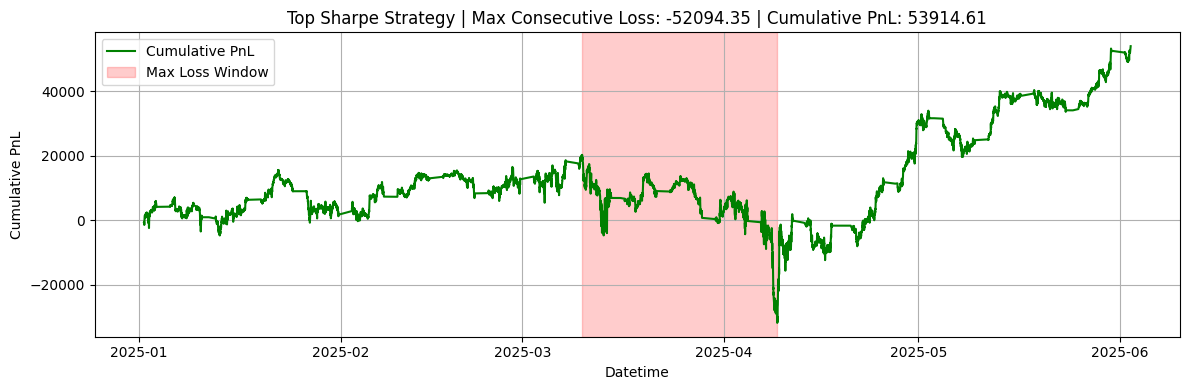

💣 Max Consecutive PnL Loss: -52094.35
📆 Period: 2025-03-10 05:40:00-04:00 → 2025-04-09 06:20:00-04:00
✅ Saved best_strategy_results.csv


In [12]:
best_result = None

def compute_max_consecutive_loss(df):
    """
    Calculates the worst cumulative loss (drawdown) from any starting point.
    """
    pnl_series = df['pnl'].values
    max_loss = 0.0
    start_idx = 0
    end_idx = 0

    for i in range(len(pnl_series)):
        cumulative = 0.0
        for j in range(i, len(pnl_series)):
            cumulative += pnl_series[j]
            if cumulative < max_loss:
                max_loss = cumulative
                start_idx = i
                end_idx = j

    return max_loss, df['entry_time'].iloc[start_idx], df['entry_time'].iloc[end_idx]


for r in all_results:
    df = r['results'].copy()
    df = df.sort_values(by='entry_time')
    df['cumulative_pnl'] = df['pnl'].cumsum()

    if (
        df['cumulative_pnl'].iloc[-1] > 0 and
        r['sharpe'] > 1 and
        r['trades'] > 1 and
        r['win_rate'] > 0.001 and
        r['profit_factor'] > 0.01 and
        r['expectancy'] > 0.01 and
        r['pnl'] > 100
    ):
        if best_result is None or r['sharpe'] > best_result['sharpe']:
            best_result = r.copy()
            best_result['cumulative_pnl'] = df['cumulative_pnl']
            best_result['entry_time'] = df['entry_time']

            # === Calculate max drawdown (largest PnL loss from peak)
            cumulative = df['cumulative_pnl']
            rolling_max = cumulative.cummax()
            drawdowns = cumulative - rolling_max
            max_drawdown = drawdowns.min()  # Most negative drop
            max_drawdown_start = rolling_max[drawdowns.idxmin()]
            best_result['max_drawdown'] = max_drawdown

# === Plot the best one ===
# === After determining best_result
if best_result:
    df = best_result['results'].copy()
    df = df.sort_values(by='entry_time')
    df['cumulative_pnl'] = df['pnl'].cumsum()

    max_loss, loss_start, loss_end = compute_max_consecutive_loss(df)

    # === Plot
    plt.figure(figsize=(12, 4))
    plt.plot(df['entry_time'], df['cumulative_pnl'], label='Cumulative PnL', color='green')
    plt.axvspan(loss_start, loss_end, color='red', alpha=0.2, label='Max Loss Window')
    plt.title(f"Top Sharpe Strategy | Max Consecutive Loss: {max_loss:.2f} | Cumulative PnL: {best_result['pnl']:.2f}")
    plt.xlabel("Datetime")
    plt.ylabel("Cumulative PnL")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"💣 Max Consecutive PnL Loss: {max_loss:.2f}")
    print(f"📆 Period: {loss_start} → {loss_end}")
    best_result['results'].to_csv("best_strategy_results.csv", index=False)
    print("✅ Saved best_strategy_results.csv")
else:
    print("❌ No strategy met the conditions.")
